<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [115]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovateable:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [116]:
# Load the data
house = pd.read_csv('./Dataset/housing.csv', index_col='Id')
#                     keep_default_na=False,
#                     na_values=['', '#N/A', '#N/A N/A', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '#NA',  # 'NA',
#                                '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'])

#### 1. Perform any cleaning, feature engineering, and EDA you deem necessary.

In [117]:
house.shape

(1460, 80)

In [118]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [119]:
# after checking the Id column it was imported as index column directly
#house.set_index('Id', inplace=True)

In [120]:
pd.set_option('max_columns', house.shape[1])

In [121]:
house.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [122]:
house.tail()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,240,TA,TA,Y,366,0,112,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,6,1965,1965,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,CBlock,TA,TA,No,BLQ,830,LwQ,290,136,1256,GasA,Gd,Y,SBrkr,1256,0,0,1256,1,0,1,1,3,1,TA,6,Typ,0,NaN,Attchd,1965.0,Fin,1,276,TA,TA,Y,736,68,0,0,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


In [123]:
house.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
590,40,RM,50.0,9100,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,Feedr,1Fam,1Story,5,6,1930,1960,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,742,742,GasA,TA,Y,FuseA,779,0,156,935,0,0,1,0,2,1,TA,4,Typ,0,NaN,Detchd,1988.0,Unf,1,308,TA,TA,P,0,0,0,0,0,0,NaN,NaN,Shed,600,8,2008,WD,Normal,79500
376,30,RL,NaN,10020,Pave,NaN,IR1,Low,AllPub,Inside,Sev,Edwards,Norm,Norm,1Fam,1Story,1,1,1922,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Fa,Fa,BrkTil,Fa,Po,Gd,BLQ,350,Unf,0,333,683,GasA,Gd,N,FuseA,904,0,0,904,1,0,0,1,1,1,Fa,4,Maj1,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,3,2009,WD,Normal,61000
173,160,RL,44.0,5306,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,2Story,7,7,1987,1987,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,Gd,PConc,Gd,Gd,No,GLQ,495,Rec,215,354,1064,GasA,Gd,Y,SBrkr,1064,703,0,1767,1,0,2,0,2,1,Gd,5,Typ,1,TA,Attchd,1987.0,RFn,2,504,Gd,TA,Y,441,35,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,239000
986,190,RL,68.0,10880,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,2fmCon,1Story,5,5,1950,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1040,Unf,0,124,1164,GasW,TA,N,SBrkr,1164,0,0,1164,1,0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,1950.0,Unf,1,240,TA,TA,Y,0,48,0,0,0,0,NaN,NaN,NaN,0,8,2008,ConLD,Normal,125000
942,60,RL,NaN,8755,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,Gilbert,RRNn,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,BrkFace,298.0,Gd,TA,PConc,Gd,TA,No,ALQ,772,Unf,0,220,992,GasA,Ex,Y,SBrkr,1022,1038,0,2060,1,0,2,1,3,1,Gd,8,Typ,1,TA,BuiltIn,1999.0,RFn,2,390,TA,TA,Y,0,0,0,168,0,0,NaN,GdPrv,NaN,0,6,2009,WD,Normal,214000


In [124]:
house.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [125]:
# checking if variables are the same like in the description
for col in house.describe(include='O').columns:
    print(f'{col} \n{house[col].unique()}\n')    

MSZoning 
['RL' 'RM' 'C (all)' 'FV' 'RH']

Street 
['Pave' 'Grvl']

Alley 
[nan 'Grvl' 'Pave']

LotShape 
['Reg' 'IR1' 'IR2' 'IR3']

LandContour 
['Lvl' 'Bnk' 'Low' 'HLS']

Utilities 
['AllPub' 'NoSeWa']

LotConfig 
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']

LandSlope 
['Gtl' 'Mod' 'Sev']

Neighborhood 
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']

Condition1 
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']

Condition2 
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']

BldgType 
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']

HouseStyle 
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']

RoofStyle 
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']

RoofMatl 
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']

Ex

In [126]:
house['BldgType'].value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [127]:
# rename it like in the data description
house['BldgType'].replace({'2fmCon': '2FmCon', 'Twnhs': 'TwnhsI'}, inplace=True)  # is Twnhs TwnhsI or TwnhsE?
house['Exterior2nd'].replace({'CmentBd': 'CemntBd', 'Wd Shng': 'WdShing', 'Brk Cmn': 'BrkComm'}, inplace=True)
house['MSZoning'].replace({'C (all)': 'C'}, inplace=True)  
house['Neighborhood'].replace({'NAmes': 'Names'}, inplace=True)

In [128]:
# check for duplicated rows
house.duplicated().sum()  

0

In [129]:
house.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageCond        81
GarageFinish      81
GarageQual        81
GarageYrBlt       81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
MasVnrType         8
Electrical         1
RoofMatl           0
dtype: int64

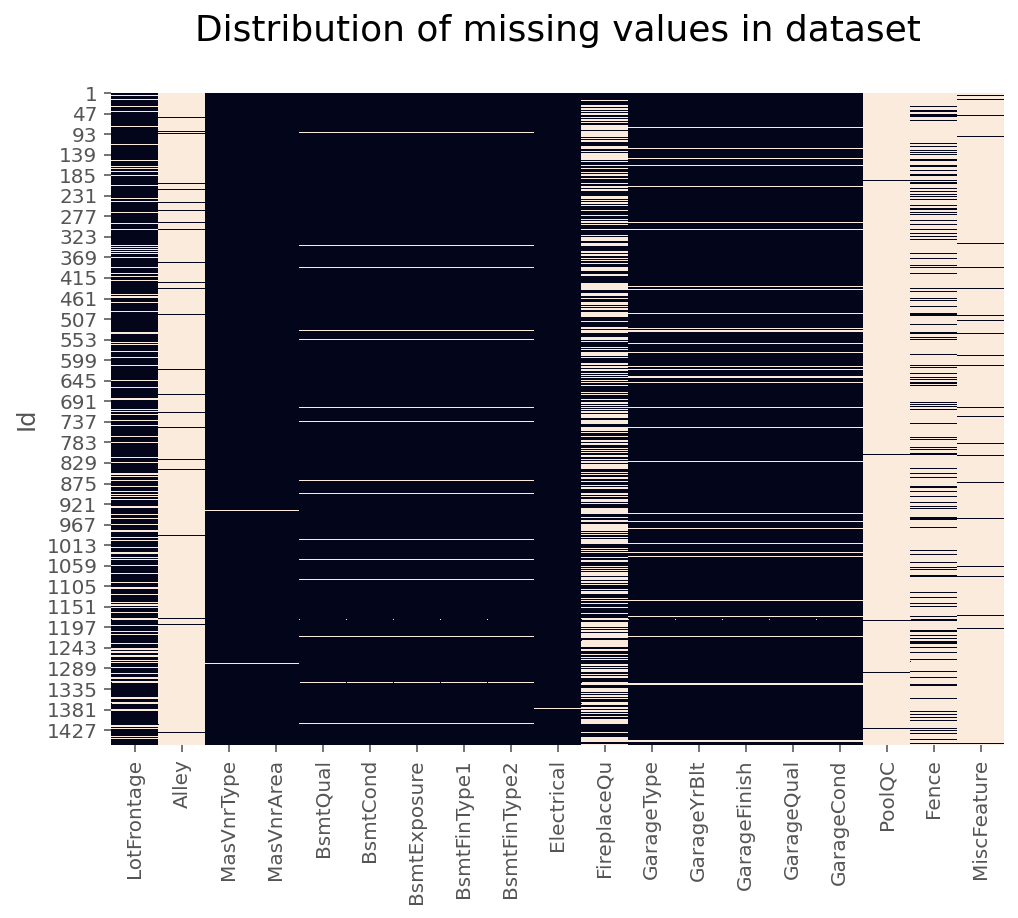

In [130]:
plt.figure(figsize=(8, 6))
columns_missing_values = house.columns[house.isnull().sum() > 0]
sns.heatmap(house.loc[:, columns_missing_values].isnull(), cbar=False)
plt.title('Distribution of missing values in dataset\n', fontsize=18)
plt.show()

Some features with string values using "NA" as an abbreviation for the absence of something specific instead of indicating that the value is missing. But also numerical features are using "NA" values, but in this case to state that the value is missing. Due to this inconsistency each value with "NA" is imported as a null value and only afterwards traded respectively to its original meaning. 

In [131]:
# show only columns which have nan values and have type 'object'
s_object = house[columns_missing_values].dtypes == 'object'
s_object[s_object].index

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [132]:
s_numeric = house[columns_missing_values].dtypes != 'object'
s_numeric[s_numeric].index

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

In [133]:
# MasVnrType is using 'None' as a feature which is converted correctly,
# meaning nan values are not referring to that
house['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [134]:
# assuming that 'NA' was mistakenly converted to nan value
# but na_values attribut in read_csv() isn't used because of inconsistency in the dataset
# the 'NA' string is also used for real nan values in columns with numeric types
###
# FireplaceQu column is using 'NA' for 'No Fireplace'
# MiscFeature column is using 'NA' for 'None'
# PoolQC column is using 'NA' for 'No Pool'
# Fence column is using 'NA' for 'No Fence'
# Alley column is using 'NA' for 'No alley access'
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 columns are using 'NA' for 'No Basement'
# GarageType, GarageFinish, GarageQual, GarageCond are using 'NA' for 'No Garage'
house[['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = \
house[['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('NA')

In [135]:
# drop following columns because of too many missing values
# house.drop(columns=['Alley', 'PoolQC', 'MiscFeature', 'Fence'], inplace=True)

In [136]:
lotfrontage = house['LotFrontage'].copy()

In [137]:
# fill with mean value
house['LotFrontage'].fillna(house['LotFrontage'].mean(), inplace=True)
print('Skew before cleaning:', round(lotfrontage.skew(), 2))
print('Skew after cleaning:', round(house['LotFrontage'].skew(), 2))

Skew before cleaning: 2.16
Skew after cleaning: 2.38


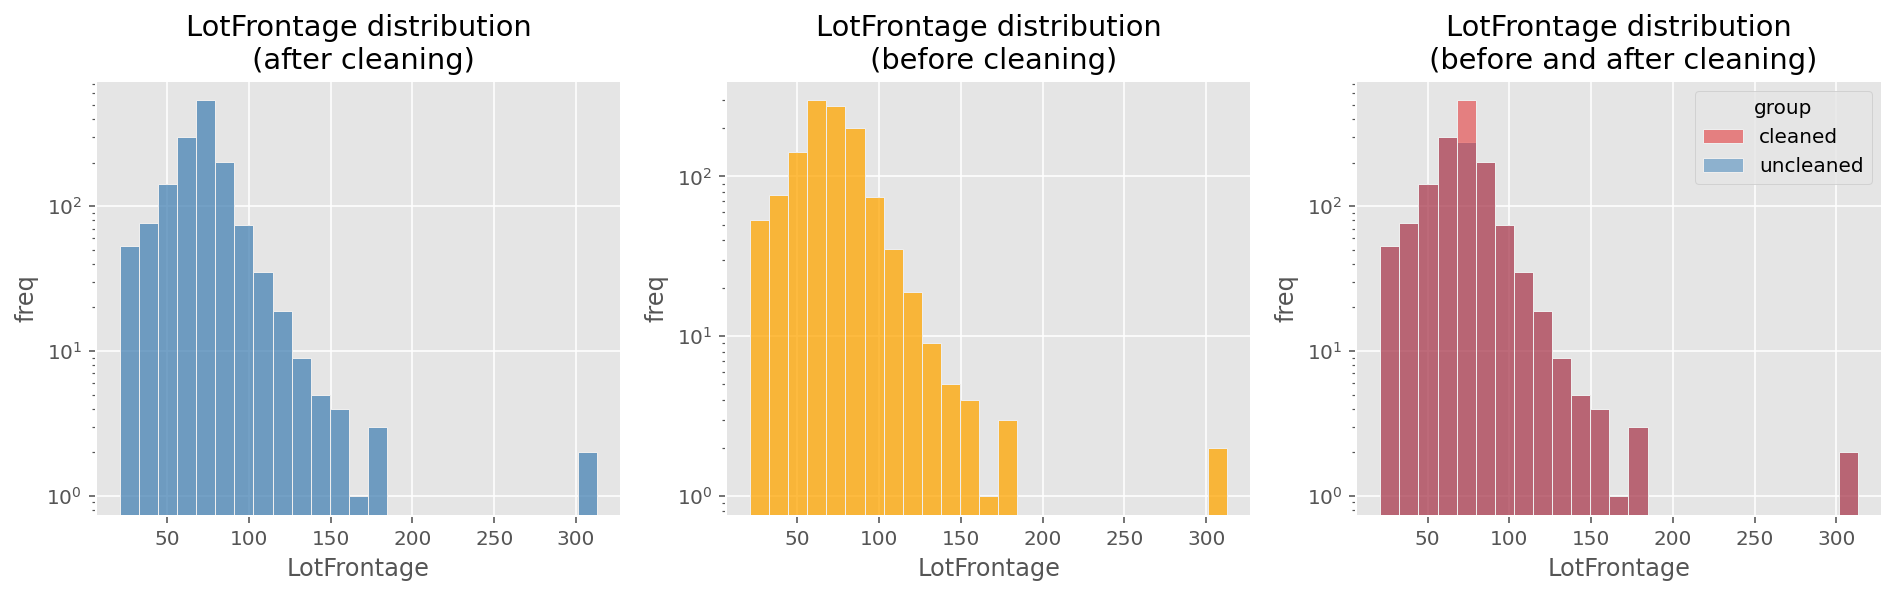

In [138]:
def compare_cleaned_data(col_clean, col_unclean):
    """
    Function creates three histograms. First one shows the distribution of the cleaned data, 
    second of the original data and last plot shows both distribution at once.
    """
    fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
    sns.histplot(col_clean, bins=25, kde=False, color= 'steelblue', ax=ax[0])
    ax[0].set_ylabel('freq')
    ax[0].set_title(f'{col_clean.name} distribution\n (after cleaning)')
    ax[0].set_yscale('log')

    sns.histplot(col_unclean, bins=25, kde=False, color='orange', ax=ax[1])
    ax[1].set_ylabel('freq')
    ax[1].set_title(f'{col_unclean.name} distribution\n (before cleaning)')
    ax[1].set_yscale('log')
    
    col_clean, col_unclean = pd.DataFrame(col_clean), pd.DataFrame(col_unclean)
    col_unclean['group'] = 'uncleaned'
    col_clean['group'] = 'cleaned'
    df = pd.concat([col_clean, col_unclean], axis=0).reset_index(drop=True)
    sns.histplot(df, x=df.iloc[:, 0], bins=25, hue='group', palette='Set1', ax=ax[2])
    ax[2].set_ylabel('freq')
    ax[2].set_title(f'{df.columns[0]} distribution\n (before and after cleaning)')
    ax[2].set_yscale('log')
    return fig, ax

fig, ax = compare_cleaned_data(house['LotFrontage'], lotfrontage)

In [139]:
# check null values per row
pd.DataFrame(house.isnull().sum(axis=1).value_counts().sort_index(ascending=False), 
             columns=['freq']).reset_index().rename(columns={'index': 'nan_values'})

,nan_values,freq
0,2,8
1,1,82
2,0,1370


In [140]:
# a list with column names which still have null values
columns_with_nan = house.columns[(house.isnull().sum() > 0)].tolist()
columns_with_nan

['MasVnrType', 'MasVnrArea', 'Electrical', 'GarageYrBlt']

In [141]:
# split the remaining column names with null values by their type 
# in numerical or object
columns_obj_nan = []
columns_numerical_nan = []
for col in columns_with_nan:
    #print(col, house[col].dtypes)
    if house[col].dtype == object:
        columns_obj_nan.append(col)
    elif np.issubdtype(house[col].dtype, np.number):  # check if type is numerical
        columns_numerical_nan.append(col)

In [142]:
columns_obj_nan

['MasVnrType', 'Electrical']

In [143]:
columns_numerical_nan

['MasVnrArea', 'GarageYrBlt']

Skew of MasVnrArea before cleaning: 2.67
Skew of MasVnrArea after cleaning: 2.68
Skew of GarageYrBlt before cleaning: -0.65
Skew of GarageYrBlt after cleaning: -0.67


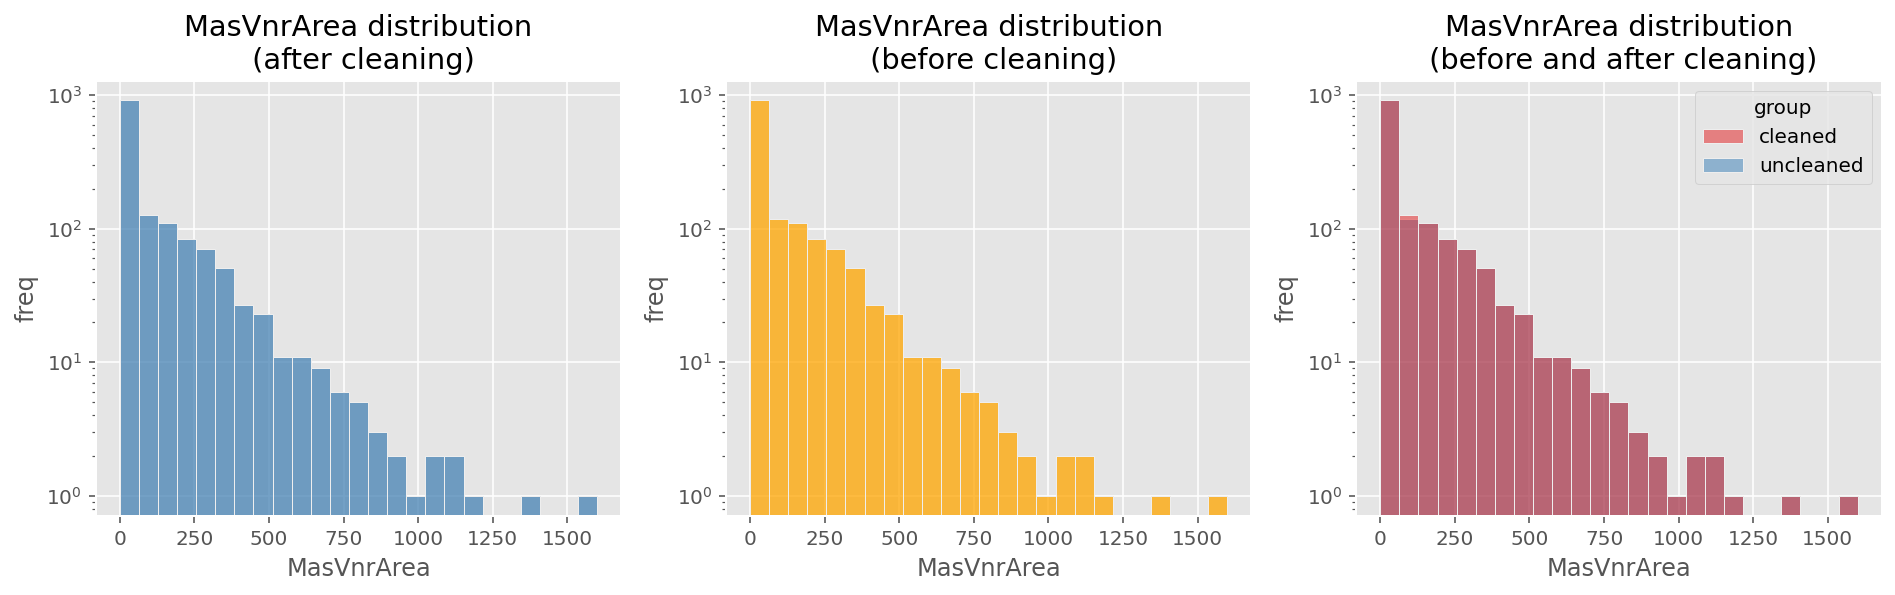

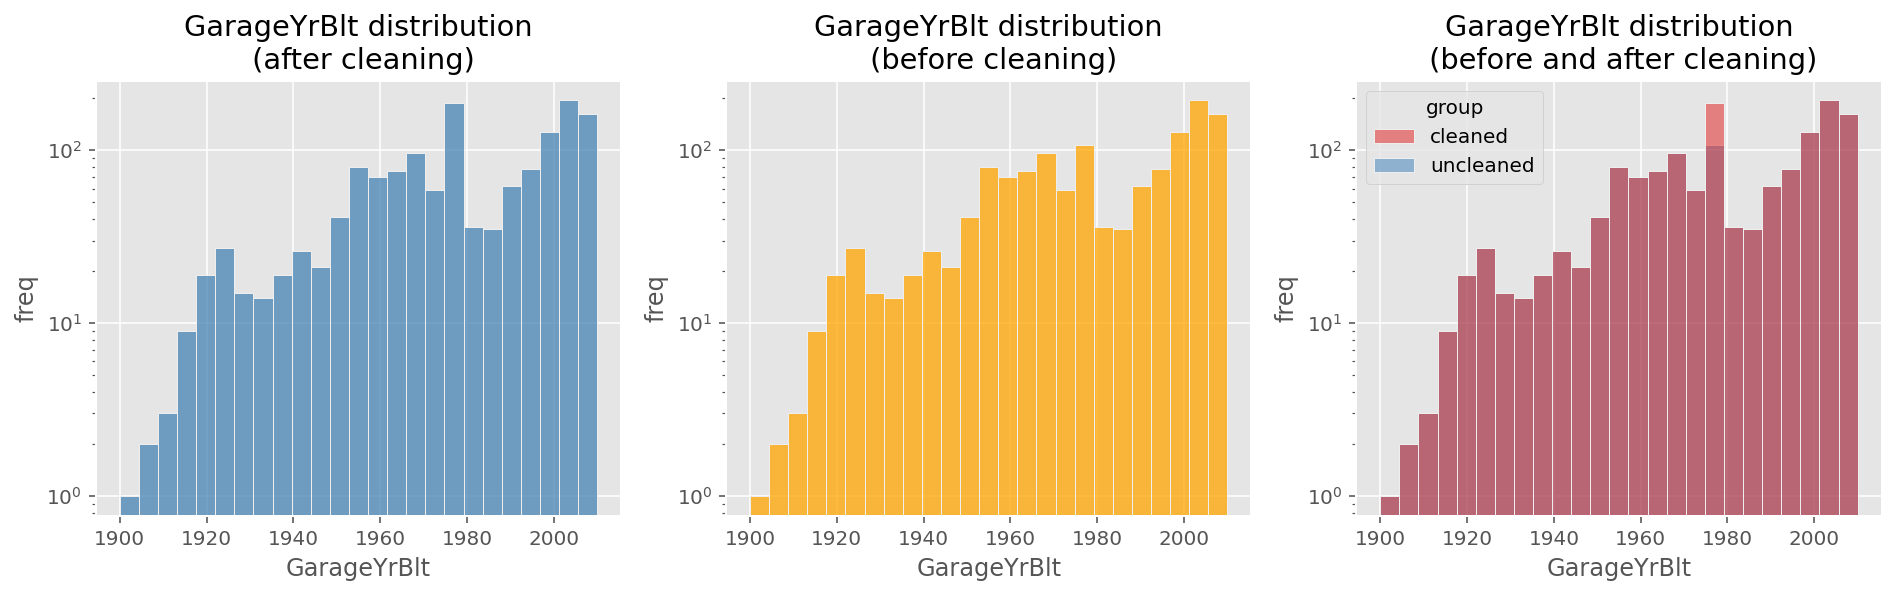

In [144]:
# fill null values of numerical columns with their mean value
for col in columns_numerical_nan:
    column_uncleaned = house[col].copy()
    house[col].fillna(house[col].mean(), inplace=True)
    compare_cleaned_data(house[col], column_uncleaned)
    print(f'Skew of {col} before cleaning: {round(column_uncleaned.skew(), 2)}')
    print(f'Skew of {col} after cleaning: {round(house[col].skew(), 2)}')

In [145]:
# check how many rows include null values
indices_nan = []
for col in columns_obj_nan:
    indices_nan.extend(house[house[col].isnull()].index.tolist())
    house[house[col].isnull()].replace(np.nan, 'None')
rows_with_nan = len(set(indices_nan))
rows_with_nan

9

In [146]:
house.loc[house[columns_obj_nan].isnull().values, columns_obj_nan]

,MasVnrType,Electrical
Id,,
235,NaN,SBrkr
530,NaN,SBrkr
651,NaN,SBrkr
937,NaN,SBrkr
974,NaN,SBrkr
978,NaN,SBrkr
1244,NaN,SBrkr
1279,NaN,SBrkr
1380,None,NaN


In [147]:
# replace remaining nan values of string features with 'Missing'
for col in columns_obj_nan:
    house[col].replace(np.nan, 'Missing', inplace=True)

In [148]:
for col in columns_obj_nan:
    print(house[col].unique())

['BrkFace' 'None' 'Stone' 'BrkCmn' 'Missing']
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' 'Missing']


In [149]:
# all nan values are cleaned up
house.isnull().sum().sum()

0

In [150]:
# checking for outliers with the IQR score technique

def data_overview(df, sort='Missing%'):
    """
    This function returns an overview of the columns of the passed dataframe about the data type, 
    percentage of missing values, statistical measurements and the amount of outliers (IQR technique).
    For numerical columns it returns following statistics: [min, median, max, mean]
    For categorical columns it returns the number of categories.
    
    Parameters:
    df [pandas.DataFrame]: DataFrame
    sort [str]: column name that it should sort by, options: 'Types', 'Missing%', 'Overview', 'Outliers'
    
    Returns:
    explo [pandas.DataFrame]: DataFrame with overview about the features
    """
    
    list_of_numerics = df.select_dtypes(include=['float','int']).columns
    types = df.dtypes
    missing = round((df.isnull().sum()/df.shape[0]),3)*100
    overview = df.apply(lambda x: str([round(x.min()), 
                                   round(x.quantile(0.5)),
                                   round(x.max()), 
                                   round(x.mean())])
                        if x.name in list_of_numerics else x.nunique())
    outliers = df.apply(lambda x: sum(
                                     (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25))))|
                                     (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25))))
                                     if x.name in list_of_numerics else ''))
    explo = pd.DataFrame({'Types': types,
                          'Missing%': missing,
                          'Overview': overview,
                          'Outliers': outliers})
    return explo.sort_values(by=sort, ascending=False)

In [151]:
house_numericals = house[house.describe(include=np.number).columns].copy()
# data_overview(house, 'Outliers')
data_overview(house_numericals, 'Outliers')

,Types,Missing%,Overview,Outliers
EnclosedPorch,int64,0.0,"[0, 0, 552, 22]",208
BsmtFinSF2,int64,0.0,"[0, 0, 1474, 47]",167
OverallCond,int64,0.0,"[1, 5, 9, 6]",125
ScreenPorch,int64,0.0,"[0, 0, 480, 15]",116
LotFrontage,float64,0.0,"[21, 70, 313, 70]",106
MSSubClass,int64,0.0,"[20, 50, 190, 57]",103
MasVnrArea,float64,0.0,"[0, 0, 1600, 104]",98
BsmtHalfBath,int64,0.0,"[0, 0, 2, 0]",82
OpenPorchSF,int64,0.0,"[0, 25, 547, 47]",77
LotArea,int64,0.0,"[1300, 9478, 215245, 10517]",69


In [152]:
house.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,23.994583,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1978.506164,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [153]:
from sklearn.preprocessing import normalize

In [154]:
house_stand = pd.DataFrame(normalize(house.select_dtypes(exclude='O'), axis=0), 
                           columns=house.select_dtypes(exclude='O').columns)

In [155]:
house_stand.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.022151,0.023167,0.015255,0.029293,0.023017,0.026589,0.026409,0.024642,0.029044,0.0,0.005460,0.019570,0.018285,0.040088,0.0,0.027902,0.039014,0.0000,0.031548,0.041416,0.026345,0.02447,0.031169,0.000000,0.026493,0.027282,0.027632,0.000000,0.019705,0.0,0.0,0.0,0.0,0.0,0.007613,0.026174,0.027617
1,0.007384,0.028513,0.017331,0.025108,0.036827,0.026231,0.026053,0.000000,0.040234,0.0,0.010338,0.028851,0.026958,0.000000,0.0,0.020592,0.000000,0.1066,0.031548,0.000000,0.026345,0.02447,0.023377,0.029424,0.026136,0.027282,0.023195,0.049744,0.000000,0.0,0.0,0.0,0.0,0.0,0.019032,0.026161,0.024041
2,0.022151,0.024236,0.020310,0.029293,0.023017,0.026563,0.026396,0.020367,0.019994,0.0,0.015799,0.021033,0.019652,0.040652,0.0,0.029142,0.039014,0.0000,0.031548,0.041416,0.026345,0.02447,0.023377,0.029424,0.026467,0.027282,0.030657,0.000000,0.013567,0.0,0.0,0.0,0.0,0.0,0.034258,0.026174,0.029604


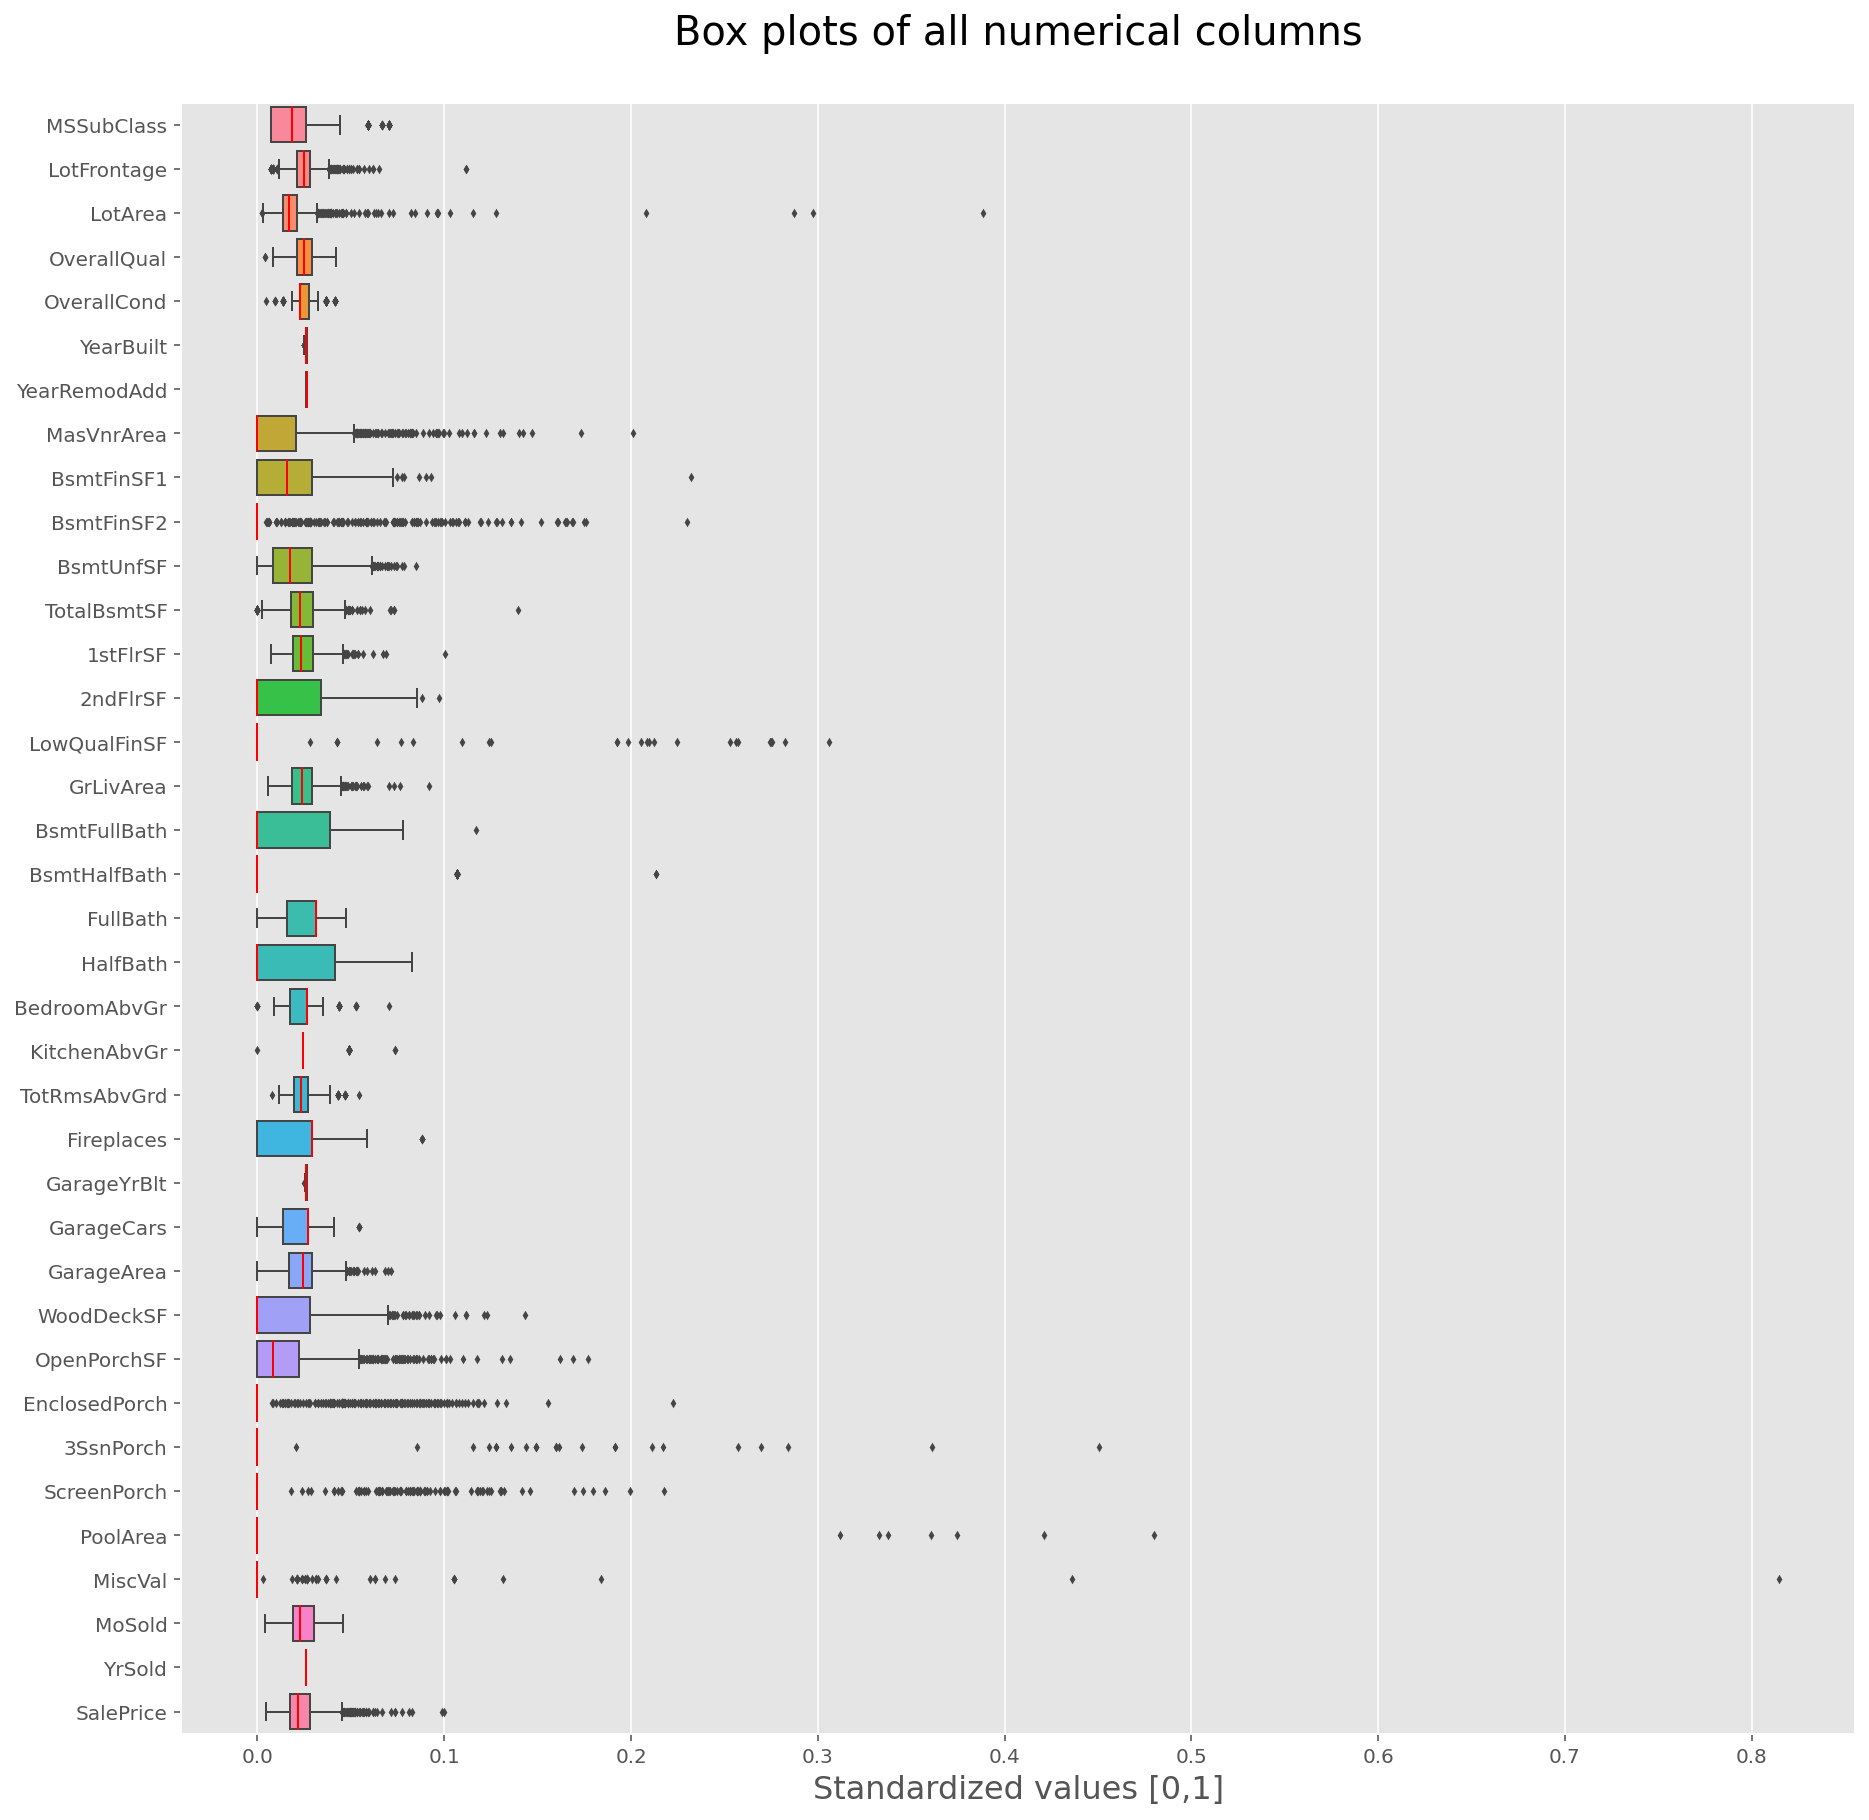

In [156]:
fig, ax = plt.subplots(figsize=(15,15))
sns.boxplot(data=house_stand, orient='h', fliersize=2,
            linewidth=1, notch=False, saturation=1, 
            whis=1.5, medianprops={"color":"red"}, ax=ax)
ax.set_title('Box plots of all numerical columns\n', fontsize=20)
ax.set_xlabel('Standardized values [0,1]', fontsize=16)
plt.show()

In [157]:
# check outliers with the IQR score technique if they are further away than 1.5 times of the interquartile range
# but with that defintion it would remove too many rows why it wasn't applied
Q1 = house.quantile(0.25)
Q3 = house.quantile(0.75)
IQR = Q3 - Q1

house_outliers = house[~((house < (Q1 - 1.5 * IQR)) | (house > (Q3 + 1.5 * IQR))).any(axis=1)]
house_outliers.shape

(557, 80)

In [158]:
import scipy.stats as stats

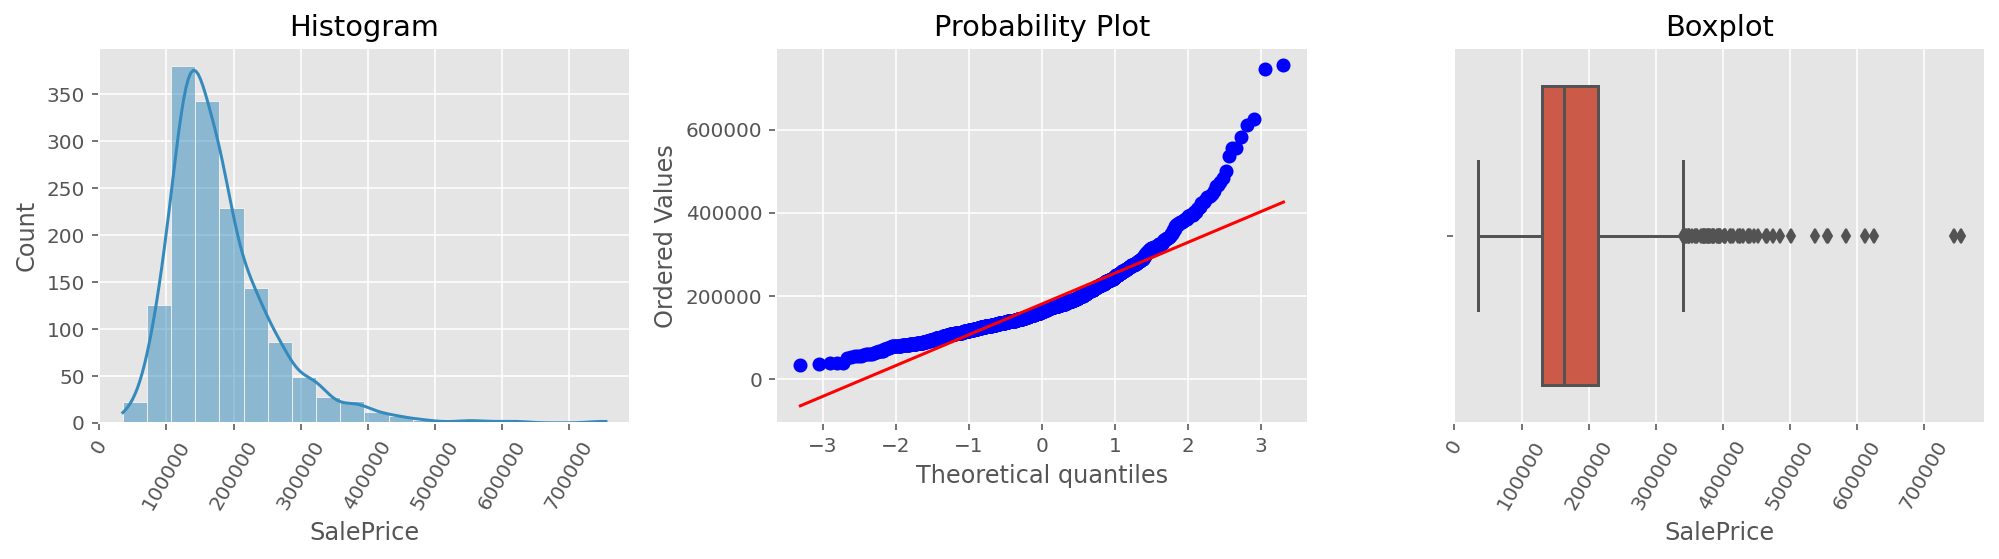

In [159]:
# check outliers of the price
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
hist = sns.histplot(house['SalePrice'], kde=True, bins=20, ax=ax[0])
stats.probplot(house['SalePrice'], dist='norm', plot=ax[1])
box = sns.boxplot(x=house['SalePrice'], orient='h', ax=ax[2])
ax[0].set_title('Histogram')
ax[2].set_title('Boxplot')
plt.setp(hist.get_xticklabels(), rotation=60)
plt.setp(box.get_xticklabels(), rotation=60)
plt.tight_layout()
plt.show()

In [160]:
def find_boundaries(df, col, distance):
    """Returns lower and upper outlier boundaries. Use 3 for distance when having extremly skewed data,
    else 1.5."""
    
    IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
    lower_boundary = df[col].quantile(0.25) - (IQR * distance)
    upper_boundary = df[col].quantile(0.75) + (IQR * distance)
    
    return lower_boundary, upper_boundary

In [161]:
print(f'total number of houses: {len(house)}')
lower_price, upper_price = find_boundaries(house, 'SalePrice', 3)
lower_price = lower_price if lower_price > 0 else 0
print(f"houses that cost more than ${upper_price}: {len(house[house['SalePrice'] > upper_price])}")
print(f"houses that cost less than ${lower_price}: {len(house[house['SalePrice'] < lower_price])}")

total number of houses: 1460
houses that cost more than $466075.0: 12
houses that cost less than $0: 0


In [162]:
# most expensive houses above the upper limit of the sale price are removed
most_expensive_houses = house.sort_values(by='SalePrice', ascending=False)[:12]
house_df = house[~house.index.isin(most_expensive_houses.index)]
most_expensive_houses[['LotArea', 'GrLivArea', 'SalePrice', 'MSZoning']]

,LotArea,GrLivArea,SalePrice,MSZoning
Id,,,,
692,21535,4316,755000,RL
1183,15623,4476,745000,RL
1170,35760,3627,625000,RL
899,12919,2364,611657,RL
804,13891,2822,582933,RL
1047,16056,2868,556581,RL
441,15431,2402,555000,RL
770,53504,3279,538000,RL
179,17423,2234,501837,RL


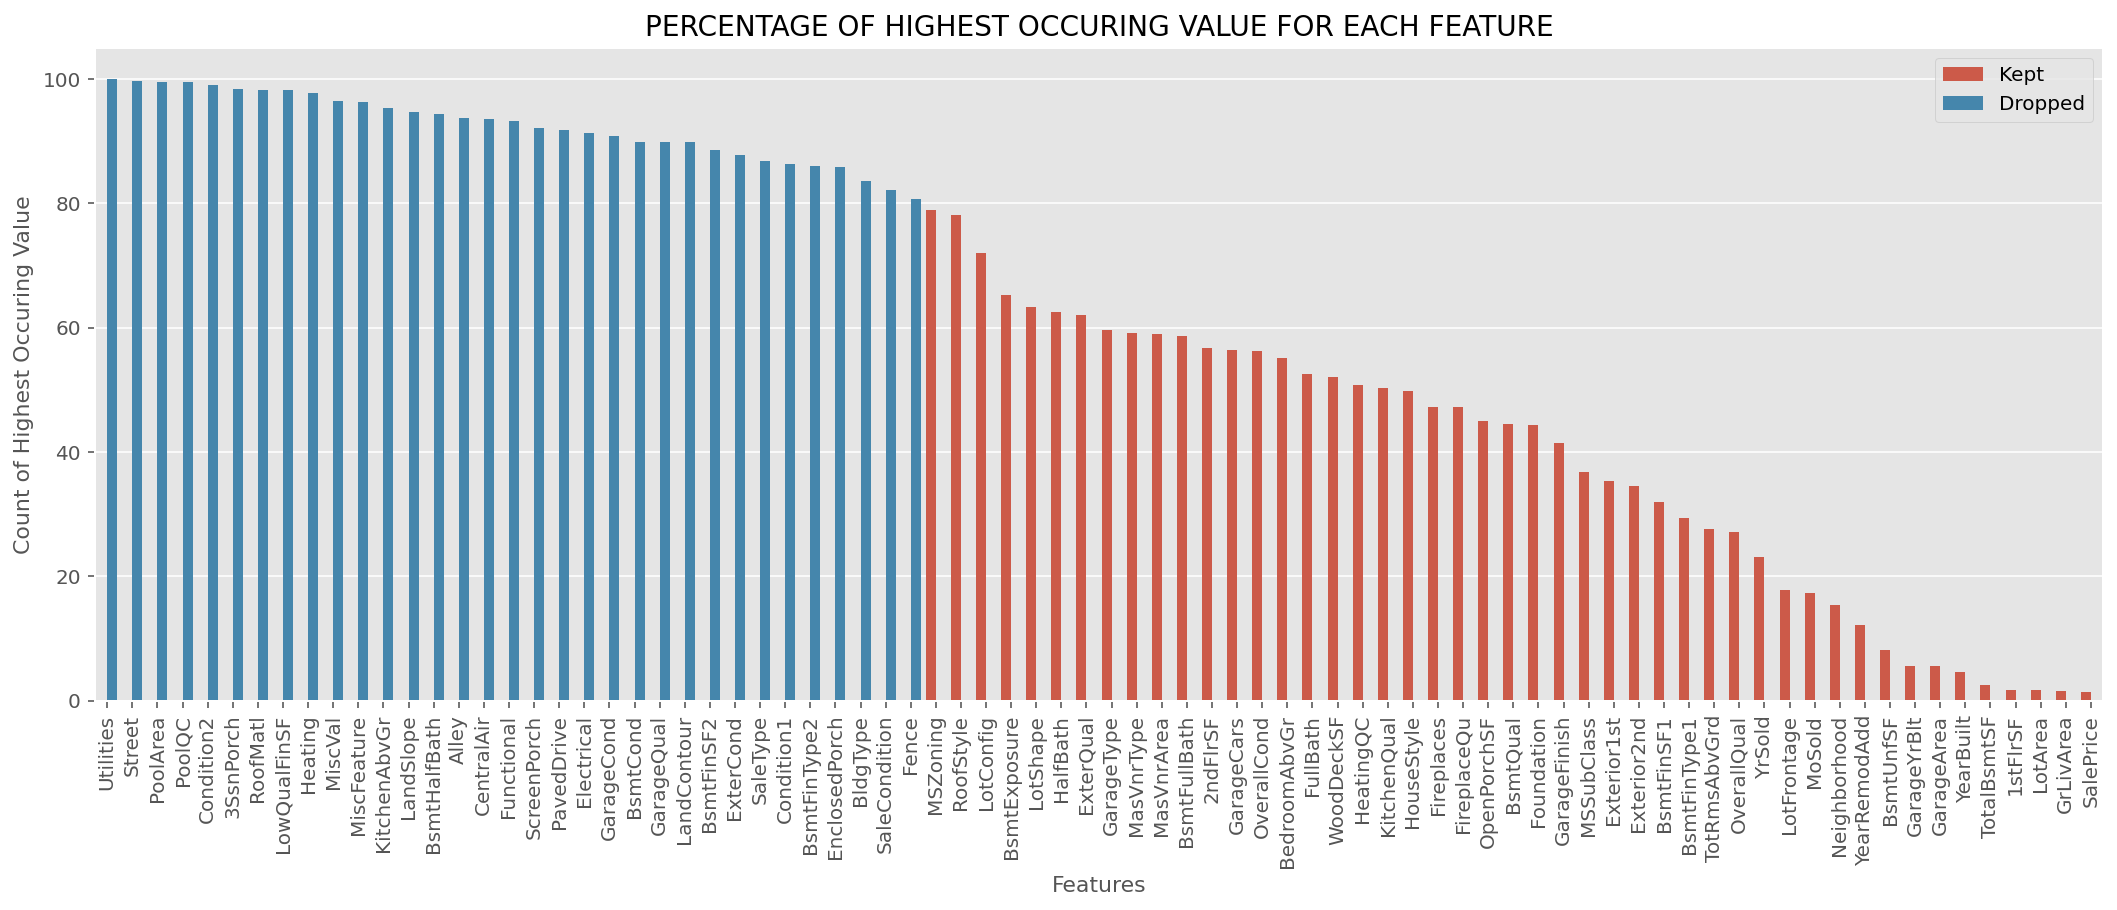

In [163]:
# checking for low variance features which aren't helpful for predicting a model (threshold 80%)
# source: https://saadabbas.net/house-price-prediction/

top_counts = []
 
for col in house.columns:
    top_counts.append(house[col].value_counts(dropna=False).max() / house.shape[0]*100)
    
counts = pd.DataFrame({'feature': house.columns, 'maxcount': top_counts}).sort_values('maxcount', ascending=False).reset_index(drop=True)
counts['low_variance'] = counts['maxcount'].map(lambda x: 'Dropped' if x >= 80 else 'Kept')
 
fig, ax = plt.subplots(1,1, figsize=(18, 6))
sns.barplot(x='feature', y='maxcount', data=counts, ax=ax, hue='low_variance', hue_order=['Kept', 'Dropped'])
ax.set_xticklabels(labels=counts['feature'], rotation=90)
ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Count of Highest Occuring Value', fontsize=11)
plt.title('PERCENTAGE OF HIGHEST OCCURING VALUE FOR EACH FEATURE', fontsize=14)
plt.legend(loc='upper right')
plt.show()

In [ ]:
# saved for task 3
sale_condition = house.loc[:, ['SaleCondition']]

In [ ]:
dropped_columns = counts[counts['low_variance'] == 'Dropped']['feature'].tolist()
if dropped_columns[0] in house:
    house.drop(columns=dropped_columns, inplace=True)

In [ ]:
house_dum = pd.get_dummies(house, drop_first=True)
house_dum.shape

In [ ]:
def correlation_heat_map(df):
    corrs = df.corr()
    fig, ax = plt.subplots(figsize=(12, 8))
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(corrs, mask=mask, annot=False, cmap='RdBu', robust=True)
    return fig, ax
#fig, ax = correlation_heat_map(house_dum)

In [ ]:
house_corr = pd.DataFrame(house_dum.corr().loc[:, 'SalePrice'], columns=['SalePrice']).drop('SalePrice')
mask_strong_corr = ((house_corr['SalePrice'] >= 0.5) | (house_corr['SalePrice'] <= -0.5))
house_corr['abs'] = abs(house_corr)
house_corr[mask_strong_corr].sort_values(by='abs', ascending=False)[['SalePrice']]

In [ ]:
price = house_corr['SalePrice']
mask_moderate_corr = (((price >= 0.3) & (price <= 0.49)) | ((price <= -0.3) & (price >= -0.49)))
house_corr[mask_moderate_corr].sort_values(by='abs', ascending=False)[['SalePrice']]

In [ ]:
sns.pairplot(data=house_dum, y_vars=['SalePrice'], x_vars=house_corr[mask_strong_corr].index.tolist()[:6])
sns.pairplot(data=house_dum, y_vars=['SalePrice'], x_vars=house_corr[mask_strong_corr].index.tolist()[6:-1])
sns.pairplot(data=house_dum, y_vars=['SalePrice'], x_vars=house_corr[mask_strong_corr].index.tolist()[-1:])
plt.show()

In [ ]:
house_dum[house_dum['TotalBsmtSF'] == house_dum['TotalBsmtSF'].max()].index[0]

In [ ]:
house_dum[house_dum['1stFlrSF'] == house_dum['1stFlrSF'].max()].index[0]

In [ ]:
house_dum['GrLivArea'].sort_values(ascending=False).iloc[:2].index.tolist()

In [ ]:
# The scatter plots indicate that the data point on index 1299 is an outlier
if 1299 in house_dum.index:
    # only for reloading purposes
    house_dum.drop(index=1299, inplace=True)

In [ ]:
def chunks(l, n):
    """Split a list l into n chunks"""
    n = max(1, n)
    return [l[i:i+n] for i in range(0, len(l), n)]

In [ ]:
moderate_corr_columns = house_corr[mask_moderate_corr].index.tolist()
moderate_corr_columns_len = len(moderate_corr_columns)

for cols in chunks(moderate_corr_columns, 6):
    sns.pairplot(data=house_dum, y_vars=['SalePrice'], x_vars=cols)

2. Be sure to remove any houses that are not residential from the dataset.

In [ ]:
house['MSZoning'].unique()

In [ ]:
for col in house_dum.columns:
    if 'MSZoning' in col:
        print(col)

In [ ]:
house_residential = house_dum[(house_dum['MSZoning_RH'] == 1) |
                              (house_dum['MSZoning_RL'] == 1) |
                              (house_dum['MSZoning_RM'] == 1)]
house_residential.shape

3. Identify **fixed** features that can predict price.

#### fixed characteristics: 
MSSubClass, MSZoning, LotFrontage, LotArea, HouseStyle, LotConfig, Foundation, LotShape, BedroomAbvGr, Neighborhood, TotRmsAbvGrd, 1stFlrSF, 2ndFlrSF, EnclosedPorch, OpenPorchSF, 3SsnPorch, ScreenPorch, WoodDeckSF, BsmtExposure, TotalBsmtSF, FullBath, GrLivArea, GarageArea, GarageCars, GarageType, GarageYrBlt, BsmtFinType1, BsmtFinType2, YearBuilt

#### renovateable characteristics:
OverallQual, OverallCond, YearRemodAdd, RoofStyle, Exterior1st, Exterior2nd, MasVnrType, ExterQual, BsmtUnfSF, HeatingQC, HalfBath, KitchenQual, GarageFinish, BsmtFinSF1, MasVnrArea, BsmtQual, BsmtFullBath, Bedroom, Kitchen, MoSold, YrSold

remaining features were dropped

In [ ]:
# filtering columns which only containing fixed features
fixed_features = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'HouseStyle', 'LotConfig', 
                  'Foundation', 'LotShape', 'BedroomAbvGr', 'Neighborhood', 'TotRmsAbvGrd', 
                  '1stFlrSF', '2ndFlrSF', 'EnclosedPorch', 'OpenPorchSF', '3SsnPorch', 'ScreenPorch', 
                  'WoodDeckSF', 'BsmtExposure', 'TotalBsmtSF', 'FullBath', 'GrLivArea', 'GarageArea', 
                  'GarageCars', 'GarageType', 'GarageYrBlt', 'BsmtFinType1', 'BsmtFinType2', 
                  'YearBuilt', 'MoSold', 'YrSold']

house_fixed_cols = house_residential.columns[
    house_residential.columns.str.contains(('|').join(fixed_features), regex=True, case=False)]

In [ ]:
# filtering which only containing renovateable features
renovateable_features = ['OverallQual', 'OverallCond', 'YearRemodAdd', 'RoofStyle', 'Exterior1st', 
                         'Exterior2nd', 'MasVnrType', 'ExterQual', 'BsmtUnfSF', 'HeatingQC', 
                         'HalfBath', 'KitchenQual', 'GarageFinish', 'BsmtFinSF1', 'MasVnrArea', 
                         'BsmtQual', 'BsmtFullBath', 'Bedroom', 'Kitchen', 'MoSold', 'YrSold']

house_renovateable_cols = house_residential.columns[
    house_residential.columns.str.contains(('|').join(renovateable_features), regex=True, case=False)]

# house_renovateable = house_residential.loc[:, house_renovateable_cols]

4. Train a model on pre-2010 data and evaluate its performance on the 2010 houses.

In [ ]:
X_train = house_dum.copy()[house_dum['YrSold'] < 2010].loc[:, house_fixed_cols].drop('YrSold', axis=1)
X_test = house_dum.copy().drop(index = X_train.index).loc[:, house_fixed_cols].drop('YrSold', axis=1)

y_train = house_dum.copy()[house_dum['YrSold'] < 2010]['SalePrice']
y_test = house_dum.copy()[house_dum['YrSold'] >= 2010]['SalePrice']

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
scaler = MinMaxScaler()  # StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

5. Characterize your model. How well does it perform? What are the best estimates of price?

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=1) 

model_ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 300), cv=kf)
model_ridge_cv.fit(X_train, y_train)
print('R2 ridge score:', round(model_ridge_cv.score(X_train, y_train), 4))

model_ridge = Ridge(alpha=model_ridge_cv.alpha_)

ridge_scores_shuffled_train = cross_val_score(model_ridge, X_train, y_train, cv=kf)

print('Mean cross validation training score (shuffled) of ridge model:', round(np.mean(ridge_scores_shuffled_train), 4))


ridge_scores_shuffled_test = cross_val_score(model_ridge, X_test, y_test, cv=kf)
print('Mean cross validation testing score (shuffled) of ridge model:', round(np.mean(ridge_scores_shuffled_test), 4))

In [ ]:
from itertools import combinations

In [ ]:
# trying to get a similar good result with only strong and moderate correlation features
strong_moderate_corr = (house_corr[mask_strong_corr]+ house_corr[mask_moderate_corr]).index
X_str_mod_corr = [col for col in fixed_features if col in strong_moderate_corr]
X_str_mod_corr

In [ ]:
combs = [c for i in range(1, len(X_str_mod_corr)+1) for c in combinations(X_str_mod_corr, i)]
len(combs)

In [ ]:
X_str_mod_corr = X_train.loc[:, X_str_mod_corr]

In [ ]:
from tqdm import tqdm

In [ ]:
R2_results = {}
model_ridge = Ridge(alpha=model_ridge_cv.alpha_)
for i, c in tqdm(enumerate(combs)):
    subX = X_str_mod_corr[list(c)]
    scores = cross_val_score(model_ridge, subX, y_train, cv=kf)
    R2_results[c] = scores.mean()

In [ ]:
results = list(R2_results.items())
results = sorted(results, key=lambda x: x[1], reverse=True)

In [ ]:
# result of only strong and moderate correlation features is a lot worse
max(results, key = lambda i : i[1])[1]

In [ ]:
model_lasso_cv = LassoCV(n_alphas=500, cv=kf, n_jobs=2) #, verbose=1
model_lasso_cv.fit(X_train, y_train)
print('R2 lasso score:', model_lasso_cv.score(X_train, y_train))

model_lasso = Lasso(alpha=model_lasso_cv.alpha_)

lasso_scores_shuffled_train = cross_val_score(model_lasso, X_train, y_train, cv=kf)
print('Mean cross validation training score (shuffled) of lasso model:', round(np.mean(lasso_scores_shuffled_train), 4))

lasso_scores_shuffled_test = cross_val_score(model_lasso, X_test, y_test, cv=kf)
print('Mean cross validation testing score (shuffled) of lasso model:', round(np.mean(lasso_scores_shuffled_test), 4))

In [ ]:
predictions = model_lasso_cv.predict(X_train)

plt.figure(figsize=(6, 6))
y_range = [y_train.min(), y_train.max()]
plt.plot(y_range, y_range, lw=2, c='k')
plt.scatter(predictions, y_train, c='b')
plt.xlabel(r'$\hat{y}$')
plt.ylabel('y')
plt.show()

In [ ]:
lasso_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': model_lasso_cv.coef_,
                            'abs_coef': np.abs(model_lasso_cv.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
lasso_coefs.coef[:20].plot(kind='barh', ax=ax)
ax.set_yticklabels(lasso_coefs.variable[:20].values)
plt.show()

In [ ]:
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

model_enet_cv = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=300, cv=kf, n_jobs=2)  # , verbose=1
model_enet_cv.fit(X_train, y_train)
print('R2 elastic net score:', round(model_enet_cv.score(X_train, y_train), 4))

model_enet = ElasticNet(alpha=model_enet_cv.alpha_, l1_ratio=model_enet_cv.l1_ratio_)

enet_scores_shuffled_train = cross_val_score(model_enet, X_train, y_train, cv=kf)
print('Mean cross validation training score (shuffled) of elastic net model:', round(np.mean(enet_scores_shuffled_train), 4))

enet_scores_shuffled_test = cross_val_score(model_enet, X_test, y_test, cv=kf)
print('Mean cross validation testing score (shuffled) of elastic net model:', round(np.mean(enet_scores_shuffled_test), 4))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

In [ ]:
pf_train = PolynomialFeatures(degree=2, include_bias=True)
pf_test = PolynomialFeatures(degree=2, include_bias=True)
X_pf_train = pf_train.fit_transform(X_train)
X_pf_test = pf_test.fit_transform(X_test)

model_lasso_cv_pol = LassoCV(n_alphas=100, cv=kf, n_jobs=6, verbose=1) #, verbose=1, alphas=alphas_range
model_lasso_cv_pol.fit(X_pf_train, y_train)

model_lasso = Lasso(alpha=model_lasso_cv_pol.alpha_)

lasso_scores_shuffled_train = cross_val_score(model_lasso, X_pf_train, y_train, cv=kf)
print('Training mean cv score of lasso (polynomial 2 degrees):', round(np.mean(lasso_scores_shuffled_train), 4))

lasso_scores_shuffled_test = cross_val_score(model_lasso, X_pf_test, y_test, cv=kf)
print('Test mean cv score of lasso (polynomial 2 degrees):', round(np.mean(lasso_scores_shuffled_test), 4))

In [ ]:
pf_train = PolynomialFeatures(degree=2, include_bias=True)
pf_test = PolynomialFeatures(degree=2, include_bias=True)
X_pf_train = pf_train.fit_transform(X_train)
X_pf_test = pf_test.fit_transform(X_test)

model_ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 200), cv=kf) #, verbose=1, alphas=alphas_range
model_ridge_cv.fit(X_pf_train, y_train)

model_ridge = Ridge(alpha=model_ridge_cv.alpha_)

ridge_scores_shuffled_train = cross_val_score(model_ridge, X_pf_train, y_train, cv=kf)
print('Training mean cv score of ridge (polynomial 2 degrees):', round(np.mean(ridge_scores_shuffled_train), 4))

ridge_scores_shuffled_test = cross_val_score(model_ridge, X_pf_test, y_test, cv=kf)
print('Test mean cv score of ridge (polynomial 2 degrees):', round(np.mean(ridge_scores_shuffled_test), 4))

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovatable features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

1. Evaluate the effect in dollars of the renovatable features. 

In [ ]:
y_actual = house_dum.SalePrice
X = pd.concat([X_train, X_test])

In [ ]:
y_predict = model_lasso_cv.predict(X)

residuals_fixed_features = y_actual - y_predict

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x=np.arange(0, len(residuals_fixed_features)), y=residuals_fixed_features, ax=ax)
ax.get_xaxis().set_visible(False)
ax.set_title('Residuals of SalePrice', fontsize=16)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.scatter(house_dum['SalePrice'], residuals_fixed_features)
plt.show()

For lower house prices the predictions are too high and for higher house prices they are too less.

In [ ]:
X_train = house_dum.copy()[house_dum['YrSold'] < 2010].loc[:, house_renovateable_cols.tolist() + house_fixed_cols.tolist()].drop('YrSold', axis=1)
X_test = house_dum.copy().drop(index = X_train.index).loc[:, house_renovateable_cols.tolist() + house_fixed_cols.tolist()].drop('YrSold', axis=1)

y_train = house_dum.copy()[house_dum['YrSold'] < 2010]['SalePrice']
y_test = house_dum.copy()[house_dum['YrSold'] >= 2010]['SalePrice']

In [ ]:
model_lasso_cv = LassoCV(n_alphas=500, cv=kf, n_jobs=2) 
model_lasso_cv.fit(X_train, y_train)
print('R2 lasso score:', model_lasso_cv.score(X_train, y_train))

model_lasso = Lasso(alpha=model_lasso_cv.alpha_)

lasso_scores_shuffled_train = cross_val_score(model_lasso, X_train, y_train, cv=kf)
print('Mean cross validation training score (shuffled) of lasso model:', round(np.mean(lasso_scores_shuffled_train), 4))

lasso_scores_shuffled_test = cross_val_score(model_lasso, X_test, y_test, cv=kf)
print('Mean cross validation testing score (shuffled) of lasso model:', round(np.mean(lasso_scores_shuffled_test), 4))

In [ ]:
# ride model better than lasso when all features included
# additionally taken the log of the target value for some feature improvements
model_ridge_cv = RidgeCV(alphas=np.logspace(-5, 5, 300), cv=kf)
model_ridge_cv.fit(X_train, np.log(y_train))
print('R2 ridge score:', round(model_ridge_cv.score(X_train, np.log(y_train)), 4))

model_ridge = Ridge(alpha=model_ridge_cv.alpha_, max_iter=100000)

ridge_scores_shuffled_train = cross_val_score(model_ridge, X_train, np.log(y_train), cv=kf)

print('Mean cross validation training score (shuffled) of ridge model:', round(np.mean(ridge_scores_shuffled_train), 4))


ridge_scores_shuffled_test = cross_val_score(model_ridge, X_test, np.log(y_test), cv=kf)
print('Mean cross validation testing score (shuffled) of ridge model:', round(np.mean(ridge_scores_shuffled_test), 4))

In [ ]:
from sklearn.metrics import mean_squared_error

# print(f'RMSE: {np.sqrt(mean_squared_error(y_train, model_ridge_cv.predict(X_train)))}')

In [ ]:
y_actual = house_dum.SalePrice
X = pd.concat([X_train, X_test])

y_predict_renovateable = model_ridge_cv.predict(X)

residuals = y_actual - np.exp(y_predict_renovateable)

fig = plt.figure(figsize=(10, 6))
plt.scatter(house_dum['SalePrice'], residuals)
plt.show()

2. How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 

In [ ]:
pd.DataFrame({'Residual_fixed': residuals_fixed_features, 
             'Residual_renovateable': residuals, 
             'Residual_diff': residuals_fixed_features - residuals,
             'SalePrice_predict_fixed': y_predict,
             'SalePrice_predict_ren': y_predict_renovateable,
             'SalePrice': y_actual}).sort_values(by='SalePrice').applymap(lambda x: round(x))

3. Investigate how much of the variance in price remaining is explained by these features.

In [ ]:
ridge_coefs = pd.DataFrame({'variable': X_train.columns,
                            'coef': model_ridge_cv.coef_,
                            'abs_coef': np.abs(model_ridge_cv.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)
ridge_coefs = ridge_coefs[ridge_coefs.variable.isin(house_renovateable_cols)]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
ridge_coefs.coef[:10].plot(kind='barh', ax=ax)
ax.set_yticklabels(ridge_coefs.variable[:10].values)
ax.set_title('Renovateable features with strongest impact\n', fontsize=16)
plt.show()

Best improvements for generating a higher selling will be using a brick face, increasing the overall quality, increasing the heating, overall and kitchen condition.

4. Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

The model shouldn't be used as a predictor so far, because there is a distortion of the prediction for cheaper and expensive houses. That's probably the reason why even a good kitchen quality can have a negative impact on the sale price.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. It is recommended to do some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [ ]:
len(house_dum.columns)

In [ ]:
plt.figure(figsize=(10,6))

sale_condition['SaleCondition'].value_counts().plot.barh()
plt.title('Counts for Sale Condition\n', fontsize=16)
plt.show()

In [ ]:
# creating a target column for abnormal conditions
# changed to binary classification because only important to know if it is abnormal or not
house_dum['AbnormalCond']= sale_condition['SaleCondition'].map(lambda x: 1 if x=='Abnorml' else 0)
abnormal_balancy = 100*house_dum['AbnormalCond'].sum()/house_dum.shape[0]
print(f'Occurence of abnormal conditions is around {round(abnormal_balancy, 1)}%')

In [ ]:
# up-sampling the minority class (randomly duplicating observations 
# from the minority class in order to reinforce its signal)

# separate majority and minority classes
house_majority = house_dum[house_dum.AbnormalCond==0]
house_minority = house_dum[house_dum.AbnormalCond==1]

# upsample minority class (sample with replacement)
house_minority_upsampled = resample(house_minority, 
                                    replace=True, 
                                    n_samples=house_majority.shape[0],    # to match majority class
                                    random_state=1) 

house_upsampled = pd.concat([house_majority, house_minority_upsampled])
house_upsampled['AbnormalCond'].value_counts()

In [ ]:
# X_train = house_upsampled[house_upsampled['YrSold'] < 2010].loc[:, house_fixed_cols].drop('YrSold', axis=1)
# X_test = house_upsampled.drop(index = X_train.index).loc[:, house_fixed_cols].drop('YrSold', axis=1)

X_train = house_upsampled[house_upsampled['YrSold'] < 2010].drop(['YrSold', 'AbnormalCond'], axis=1)
X_test = house_upsampled.drop(index = X_train.index).drop(['YrSold', 'AbnormalCond'], axis=1)

y_train = house_upsampled[house_upsampled['YrSold'] < 2010]['AbnormalCond']
y_test = house_upsampled[house_upsampled['YrSold'] >= 2010]['AbnormalCond']

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
scaler = MinMaxScaler()  # StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=1)

gs_params = {'penalty': ['l1', 'l2'],
             'solver': ['liblinear'],
             'C': np.logspace(-5, 5, 40),
             'class_weight': [None, 'balanced'],
             'fit_intercept': [True, False]
    
}

gs = GridSearchCV(lr, param_grid=gs_params, cv=5, n_jobs=4, verbose=1)

In [ ]:
# train model
gs.fit(X_train, y_train)

In [ ]:
print(f'Training score: {round(gs.best_estimator_.score(X_train, y_train), 3)}')
print(f'Testing score: {round(gs.best_estimator_.score(X_test, y_test), 3)}')
print(f'Best parameters: {gs.best_params_}')

predictions_train = gs.predict(X_train)
predictions_test = gs.predict(X_test)

In [ ]:
# training score of around 86% is a lot better then the baseline of 50%

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

In [ ]:
plot_confusion_matrix(gs, X_train, y_train, cmap='Blues', labels=[1, 0], values_format='.0f')
plt.show()

In [ ]:
print(classification_report(y_train, predictions_train))

In [ ]:
gs.predict_proba(X_train)

In [ ]:
len(gs.best_estimator_.coef_[0])

In [ ]:
pd.DataFrame({'feature': X_train.columns, 
              'coef': gs.best_estimator_.coef_[0], 
              'coef_abs': abs(gs.best_estimator_.coef_[0])}).sort_values(by='coef_abs', ascending=False)

The three strongest coefficients are GrLivArea, LotArea and SalePrice, whereas the ground live area has a positive impact and the remaining a negative one. The result can be interpreted that the chance of an abnormal classification increases when a distortion between these three features exist. Because the price of a house will probably increases with the increase of the square feet. 